In [ ]:
from torch import nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch
import math
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.manual_seed(111)

In [123]:
lr = 0.0002
nz = 100
ngf = 64
ndf = 64
image_size = 64
ngpu = 1
nc=3

In [124]:
dataset = dset.ImageFolder(root = '/content/drive/MyDrive/Colab Notebooks/icons',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [125]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10,
                                         shuffle=True, num_workers=2)

In [126]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

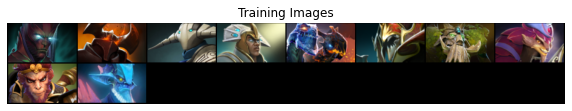

In [127]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:], padding=2, normalize=True).cpu(),(1,2,0)))

In [128]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [129]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [130]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [131]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [132]:
netD = Discriminator(ngpu).to(device)


if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [133]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [134]:
img_list = []
G_losses = []
D_losses = []
iters = 0
epochs = 10
print("Starting Training Loop...")

for epoch in range(epochs):
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, 4), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(netD(real_cpu).size(0),-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()


        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


  0%|          | 0/11 [00:00<?, ?it/s]

[0/10][0/12]	Loss_D: 2.0326	Loss_G: 9.6732	D(x): 0.6596	D(G(z)): 0.7609 / 0.0001


12it [00:00, 20.81it/s]                        
 36%|███▋      | 4/11 [00:00<00:00, 10.44it/s]

[1/10][0/12]	Loss_D: 0.3407	Loss_G: 9.3998	D(x): 0.9727	D(G(z)): 0.2157 / 0.0002


12it [00:00, 22.39it/s]                        
 36%|███▋      | 4/11 [00:00<00:00, 11.36it/s]

[2/10][0/12]	Loss_D: 0.0498	Loss_G: 7.6657	D(x): 0.9595	D(G(z)): 0.0047 / 0.0007


12it [00:00, 23.13it/s]                        
 45%|████▌     | 5/11 [00:00<00:00, 11.07it/s]

[3/10][0/12]	Loss_D: 0.2449	Loss_G: 22.4793	D(x): 0.8390	D(G(z)): 0.0000 / 0.0000


12it [00:00, 22.90it/s]
 36%|███▋      | 4/11 [00:00<00:00, 10.76it/s]

[4/10][0/12]	Loss_D: 0.0951	Loss_G: 15.3187	D(x): 0.9250	D(G(z)): 0.0000 / 0.0000


12it [00:00, 22.56it/s]                        
 45%|████▌     | 5/11 [00:00<00:00, 11.05it/s]

[5/10][0/12]	Loss_D: 0.6208	Loss_G: 22.8861	D(x): 0.9848	D(G(z)): 0.3979 / 0.0000


12it [00:00, 23.27it/s]                        
 36%|███▋      | 4/11 [00:00<00:00,  9.80it/s]

[6/10][0/12]	Loss_D: 0.0413	Loss_G: 31.8563	D(x): 0.9637	D(G(z)): 0.0000 / 0.0000


12it [00:00, 22.37it/s]                        
 45%|████▌     | 5/11 [00:00<00:00, 10.48it/s]

[7/10][0/12]	Loss_D: 0.0015	Loss_G: 14.0506	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000


12it [00:00, 22.95it/s]
 45%|████▌     | 5/11 [00:00<00:00,  9.97it/s]

[8/10][0/12]	Loss_D: 0.1217	Loss_G: 35.6587	D(x): 0.9008	D(G(z)): 0.0000 / 0.0000


12it [00:00, 23.42it/s]                       
 36%|███▋      | 4/11 [00:00<00:00, 11.04it/s]

[9/10][0/12]	Loss_D: 0.0020	Loss_G: 35.5701	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000


12it [00:00, 21.97it/s]


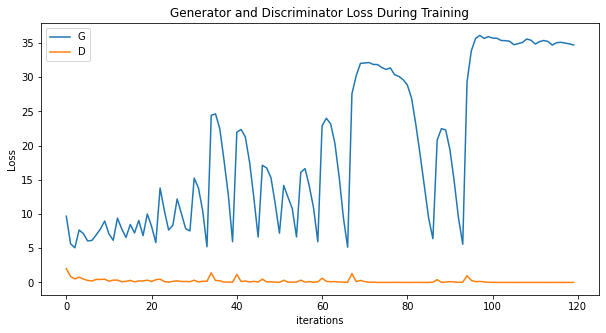

In [135]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [136]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.